In [1]:
import os
from importlib.resources import files

import copy
import numpy as np
import torch
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry, LinearField
from learn_embedding.utils import *
from learn_embedding.loss import *

## Load Dataset

In [2]:
dim = 2
num_traj = 3  # Number of trajectories
num_samples = 1000  # Desired number of samples per trajectory

train_x = np.empty((0, 2))
train_y = np.empty((0, 2))

for i in range(1, num_traj + 1):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    
    # subsample
    idx = DataProcess.subsample(data[:,:2], num_samples)
    data[idx,:2] -= data[-1,:2]
    data[-1,2:4] = np.zeros(2)
    
    # add to datset
    train_x = np.append(train_x, data[idx,:2], axis=0)
    train_y = np.append(train_y, data[idx,2:4], axis=0)

## Torch Configuration

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
train_y = torch.from_numpy(train_y).float().to(device)

## Create Model

In [4]:
# torch.manual_seed(1337)

# approximator = KernelExpansion(train_x[:, :dim])
# approximator = KernelMachine(dim, 1000, 1, length=0.4)

num_neurons = [64]
num_layers = 2
approximator = FeedForward(dim, num_neurons*num_layers, 1)

embedding = Embedding(approximator)

stiffness = SPD(dim)

attractor = train_x[-1][:2].detach()

model = FirstGeometry(embedding, attractor, stiffness,).to(device)
# TorchHelper.set_zero(model)
# TorchHelper.load(model, '../outputs/' + dataset + '_2')

## Train

In [5]:
trainer = Trainer(model, train_x, train_y)

trainer.optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
# trainer.optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, weight_decay=1e-1)

trainer.loss = torch.nn.MSELoss()
# trainer.loss = torch.nn.SmoothL1Loss()
# trainer.loss = WeighedMagnitudeDirectionLoss(magnitude_weight=0.0, direction_weight=1.0)

trainer.options(normalize=False, shuffle=True, print_loss=True,epochs=1000)

trainer.train()
# TorchHelper.save(model, '../outputs/' + dataset + '_2')

EPOCH:  0 ITER:  0 LR:  0.01 LOSS:  0.27453482151031494
EPOCH:  1 ITER:  0 LR:  0.01 LOSS:  0.1457747519016266
EPOCH:  2 ITER:  0 LR:  0.01 LOSS:  0.09912345558404922
EPOCH:  3 ITER:  0 LR:  0.01 LOSS:  0.07941742986440659
EPOCH:  4 ITER:  0 LR:  0.01 LOSS:  0.07562246918678284
EPOCH:  5 ITER:  0 LR:  0.01 LOSS:  0.07828305661678314
EPOCH:  6 ITER:  0 LR:  0.01 LOSS:  0.07953651249408722
EPOCH:  7 ITER:  0 LR:  0.01 LOSS:  0.07820019870996475
EPOCH:  8 ITER:  0 LR:  0.01 LOSS:  0.07553642243146896
EPOCH:  9 ITER:  0 LR:  0.01 LOSS:  0.07271061837673187
EPOCH:  10 ITER:  0 LR:  0.01 LOSS:  0.07026904821395874
EPOCH:  11 ITER:  0 LR:  0.01 LOSS:  0.06823664158582687
EPOCH:  12 ITER:  0 LR:  0.01 LOSS:  0.06633367389440536
EPOCH:  13 ITER:  0 LR:  0.01 LOSS:  0.06413792073726654
EPOCH:  14 ITER:  0 LR:  0.01 LOSS:  0.06116240844130516
EPOCH:  15 ITER:  0 LR:  0.01 LOSS:  0.05687962472438812
EPOCH:  16 ITER:  0 LR:  0.01 LOSS:  0.050808630883693695
EPOCH:  17 ITER:  0 LR:  0.01 LOSS:  0.04

EPOCH:  144 ITER:  0 LR:  0.01 LOSS:  0.0009629260166548193
EPOCH:  145 ITER:  0 LR:  0.01 LOSS:  0.0009584707440808415
EPOCH:  146 ITER:  0 LR:  0.01 LOSS:  0.000954019371420145
EPOCH:  147 ITER:  0 LR:  0.01 LOSS:  0.0009495499543845654
EPOCH:  148 ITER:  0 LR:  0.01 LOSS:  0.0009450597572140396
EPOCH:  149 ITER:  0 LR:  0.01 LOSS:  0.0009405838791280985
EPOCH:  150 ITER:  0 LR:  0.01 LOSS:  0.0009360964759252965
EPOCH:  151 ITER:  0 LR:  0.01 LOSS:  0.0009315967909060419
EPOCH:  152 ITER:  0 LR:  0.01 LOSS:  0.0009271022863686085
EPOCH:  153 ITER:  0 LR:  0.01 LOSS:  0.0009225861285813153
EPOCH:  154 ITER:  0 LR:  0.01 LOSS:  0.0009180533816106617
EPOCH:  155 ITER:  0 LR:  0.01 LOSS:  0.0009135151631198823
EPOCH:  156 ITER:  0 LR:  0.01 LOSS:  0.0009089575614780188
EPOCH:  157 ITER:  0 LR:  0.01 LOSS:  0.0009043943719007075
EPOCH:  158 ITER:  0 LR:  0.01 LOSS:  0.000899828621186316
EPOCH:  159 ITER:  0 LR:  0.01 LOSS:  0.0008952475618571043
EPOCH:  160 ITER:  0 LR:  0.01 LOSS:  0.00

EPOCH:  295 ITER:  0 LR:  0.01 LOSS:  0.00033498165430501103
EPOCH:  296 ITER:  0 LR:  0.01 LOSS:  0.0003331943298690021
EPOCH:  297 ITER:  0 LR:  0.01 LOSS:  0.0003314408240839839
EPOCH:  298 ITER:  0 LR:  0.01 LOSS:  0.00032972038025036454
EPOCH:  299 ITER:  0 LR:  0.01 LOSS:  0.00032803192152641714
EPOCH:  300 ITER:  0 LR:  0.01 LOSS:  0.00032637451658956707
EPOCH:  301 ITER:  0 LR:  0.01 LOSS:  0.0003247472341172397
EPOCH:  302 ITER:  0 LR:  0.01 LOSS:  0.0003231492009945214
EPOCH:  303 ITER:  0 LR:  0.01 LOSS:  0.0003215793694835156
EPOCH:  304 ITER:  0 LR:  0.01 LOSS:  0.00032003692467696965
EPOCH:  305 ITER:  0 LR:  0.01 LOSS:  0.00031852087704464793
EPOCH:  306 ITER:  0 LR:  0.01 LOSS:  0.0003170304116792977
EPOCH:  307 ITER:  0 LR:  0.01 LOSS:  0.0003155645099468529
EPOCH:  308 ITER:  0 LR:  0.01 LOSS:  0.0003141224733553827
EPOCH:  309 ITER:  0 LR:  0.01 LOSS:  0.0003127035452052951
EPOCH:  310 ITER:  0 LR:  0.01 LOSS:  0.00031130664865486324
EPOCH:  311 ITER:  0 LR:  0.01 LO

EPOCH:  432 ITER:  0 LR:  0.01 LOSS:  0.00020624868921004236
EPOCH:  433 ITER:  0 LR:  0.01 LOSS:  0.000205827847821638
EPOCH:  434 ITER:  0 LR:  0.01 LOSS:  0.0002054148499155417
EPOCH:  435 ITER:  0 LR:  0.01 LOSS:  0.0002050095790764317
EPOCH:  436 ITER:  0 LR:  0.01 LOSS:  0.00020461193344090134
EPOCH:  437 ITER:  0 LR:  0.01 LOSS:  0.0002042218402493745
EPOCH:  438 ITER:  0 LR:  0.01 LOSS:  0.0002038391394307837
EPOCH:  439 ITER:  0 LR:  0.01 LOSS:  0.00020346371456980705
EPOCH:  440 ITER:  0 LR:  0.01 LOSS:  0.00020309544925112277
EPOCH:  441 ITER:  0 LR:  0.01 LOSS:  0.00020273425616323948
EPOCH:  442 ITER:  0 LR:  0.01 LOSS:  0.00020237991702742875
EPOCH:  443 ITER:  0 LR:  0.01 LOSS:  0.0002020323881879449
EPOCH:  444 ITER:  0 LR:  0.01 LOSS:  0.00020169148046988994
EPOCH:  445 ITER:  0 LR:  0.01 LOSS:  0.0002013569901464507
EPOCH:  446 ITER:  0 LR:  0.01 LOSS:  0.0002010287862503901
EPOCH:  447 ITER:  0 LR:  0.01 LOSS:  0.00020070669415872544
EPOCH:  448 ITER:  0 LR:  0.01 LO

EPOCH:  581 ITER:  0 LR:  0.01 LOSS:  0.00017642619786784053
EPOCH:  582 ITER:  0 LR:  0.01 LOSS:  0.00017626317276153713
EPOCH:  583 ITER:  0 LR:  0.01 LOSS:  0.00017609352653380483
EPOCH:  584 ITER:  0 LR:  0.01 LOSS:  0.0001759362203301862
EPOCH:  585 ITER:  0 LR:  0.01 LOSS:  0.00017579150153324008
EPOCH:  586 ITER:  0 LR:  0.01 LOSS:  0.000175647102878429
EPOCH:  587 ITER:  0 LR:  0.01 LOSS:  0.00017549273616168648
EPOCH:  588 ITER:  0 LR:  0.01 LOSS:  0.00017533128266222775
EPOCH:  589 ITER:  0 LR:  0.01 LOSS:  0.00017517275409772992
EPOCH:  590 ITER:  0 LR:  0.01 LOSS:  0.00017502205446362495
EPOCH:  591 ITER:  0 LR:  0.01 LOSS:  0.0001748760842019692
EPOCH:  592 ITER:  0 LR:  0.01 LOSS:  0.00017472759645897895
EPOCH:  593 ITER:  0 LR:  0.01 LOSS:  0.00017457394278608263
EPOCH:  594 ITER:  0 LR:  0.01 LOSS:  0.00017441768432036042
EPOCH:  595 ITER:  0 LR:  0.01 LOSS:  0.00017426357953809202
EPOCH:  596 ITER:  0 LR:  0.01 LOSS:  0.00017411337466910481
EPOCH:  597 ITER:  0 LR:  0.

EPOCH:  722 ITER:  0 LR:  0.01 LOSS:  0.00015723374963272363
EPOCH:  723 ITER:  0 LR:  0.01 LOSS:  0.00015699111099820584
EPOCH:  724 ITER:  0 LR:  0.01 LOSS:  0.00015689183783251792
EPOCH:  725 ITER:  0 LR:  0.01 LOSS:  0.00015686383994761854
EPOCH:  726 ITER:  0 LR:  0.01 LOSS:  0.00015678012277930975
EPOCH:  727 ITER:  0 LR:  0.01 LOSS:  0.0001566017308505252
EPOCH:  728 ITER:  0 LR:  0.01 LOSS:  0.00015636722673662007
EPOCH:  729 ITER:  0 LR:  0.01 LOSS:  0.00015616182645317167
EPOCH:  730 ITER:  0 LR:  0.01 LOSS:  0.0001560205710120499
EPOCH:  731 ITER:  0 LR:  0.01 LOSS:  0.00015593355055898428
EPOCH:  732 ITER:  0 LR:  0.01 LOSS:  0.00015584673383273184
EPOCH:  733 ITER:  0 LR:  0.01 LOSS:  0.00015572599659208208
EPOCH:  734 ITER:  0 LR:  0.01 LOSS:  0.00015556192374788225
EPOCH:  735 ITER:  0 LR:  0.01 LOSS:  0.00015538082516286522
EPOCH:  736 ITER:  0 LR:  0.01 LOSS:  0.00015520810848101974
EPOCH:  737 ITER:  0 LR:  0.01 LOSS:  0.00015506336058024317
EPOCH:  738 ITER:  0 LR:  

EPOCH:  859 ITER:  0 LR:  0.01 LOSS:  0.00014131588977761567
EPOCH:  860 ITER:  0 LR:  0.01 LOSS:  0.00014122271386440843
EPOCH:  861 ITER:  0 LR:  0.01 LOSS:  0.0001411549310432747
EPOCH:  862 ITER:  0 LR:  0.01 LOSS:  0.00014108573668636382
EPOCH:  863 ITER:  0 LR:  0.01 LOSS:  0.00014100292173679918
EPOCH:  864 ITER:  0 LR:  0.01 LOSS:  0.00014089548494666815
EPOCH:  865 ITER:  0 LR:  0.01 LOSS:  0.0001407707022735849
EPOCH:  866 ITER:  0 LR:  0.01 LOSS:  0.00014063442358747125
EPOCH:  867 ITER:  0 LR:  0.01 LOSS:  0.00014049986202735454
EPOCH:  868 ITER:  0 LR:  0.01 LOSS:  0.00014037034998182207
EPOCH:  869 ITER:  0 LR:  0.01 LOSS:  0.00014025351265445352
EPOCH:  870 ITER:  0 LR:  0.01 LOSS:  0.00014014584303367883
EPOCH:  871 ITER:  0 LR:  0.01 LOSS:  0.00014004801050759852
EPOCH:  872 ITER:  0 LR:  0.01 LOSS:  0.00013995387416798621
EPOCH:  873 ITER:  0 LR:  0.01 LOSS:  0.00013986333215143532
EPOCH:  874 ITER:  0 LR:  0.01 LOSS:  0.00013977117487229407
EPOCH:  875 ITER:  0 LR:  

## Plot

In [6]:
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - std/2
max_ax = train_x.detach().max(axis=0)[0] + std/2
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')

grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)

theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

### Potential

In [7]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()

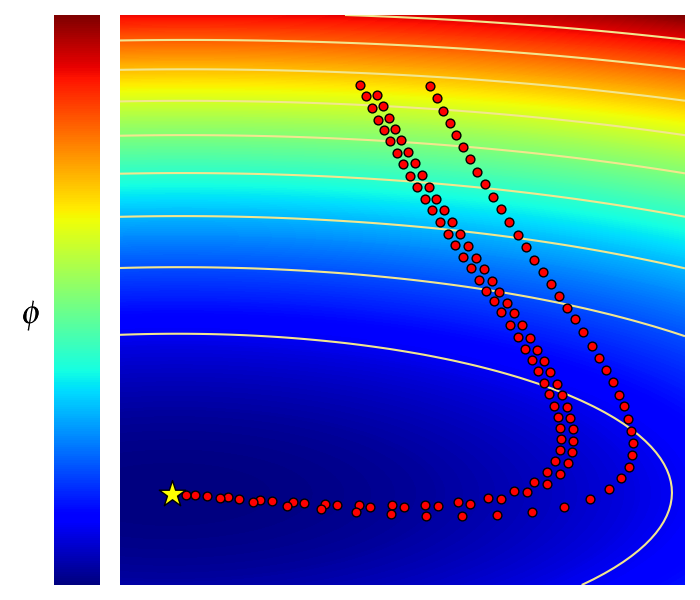

In [8]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
im = ax.contourf(x, y, potential, 500, cmap="jet")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="8%", pad=0.2)
cax.yaxis.set_label_position("left")
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=-50)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

# Adjust layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_potential_first.png', format='png', dpi=300, bbox_inches="tight")

### Vector Field

In [14]:
obstacle_radius = 0.1 # 0.05 , 0.1
obstacle = torch.tensor([[0.25,0.4]])
# obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
# obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
decay = 5e-1
lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
# phi = KernelExpansion(obstacle.to(device), kernel=SquaredExp(l=lengthscale)).to(device)
phi = KernelDeformation(obstacle.to(device), weights = torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale), tol=-0.05).to(device)
embedding.local_deformation = phi


field = model(grid_x)
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

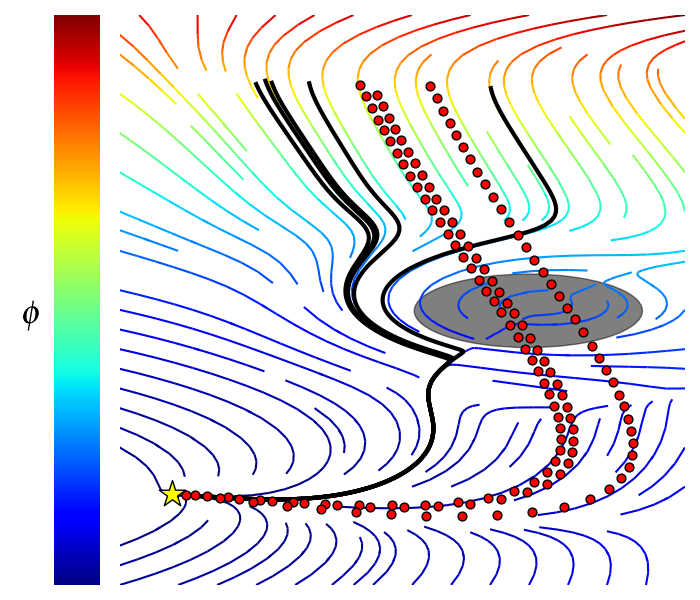

In [30]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(7, 6))

steps = 20
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="jet", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=3.0)

if hasattr(embedding, 'local_deformation'):
    for i in range(0,obstacle.shape[0],4):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius-0.02,
                            color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="8%", pad=0.2)
cax.yaxis.set_label_position("left")
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=-50)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_field_first.png', format='png', dpi=300, bbox_inches="tight") 

### Streamlines

In [20]:
# x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), length=0.01, samples=3).to(device).requires_grad_(True)
x0 = TorchHelper.grid_uniform(center=train_x[0,:].detach(), la=0.1, lb=0.01, samples=5).to(device).requires_grad_(True)
streamlines = Integrator.first_order(dynamics=model,x0=x0,T=20.0, dt=0.01).cpu().detach().numpy()

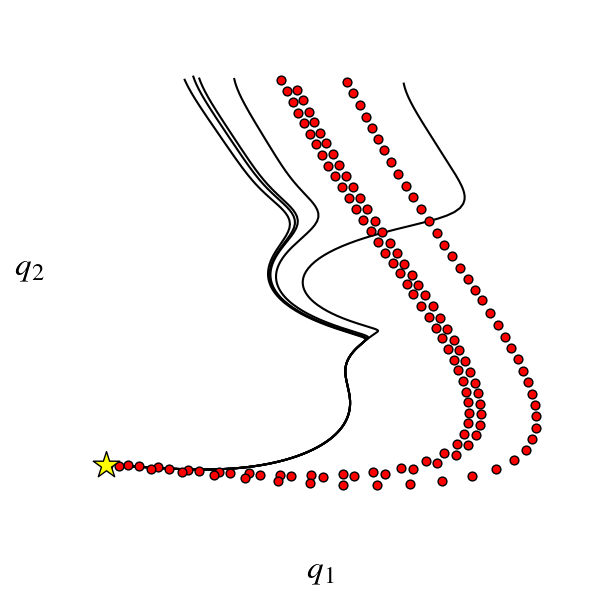

In [21]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

steps = 20
for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=1.5)

ax.scatter(train_x.cpu().detach()[::steps, 0], train_x.cpu().detach()[::steps, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel(r'$q_1$', fontsize=24)
ax.set_ylabel(r'$q_2$', fontsize=24, rotation=0, labelpad=20)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_streamlines_first.png', format='png', dpi=300, bbox_inches="tight")

### Embedding

In [26]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()
train_embedding = embedding(train_x[:,:dim]).cpu().detach().numpy()

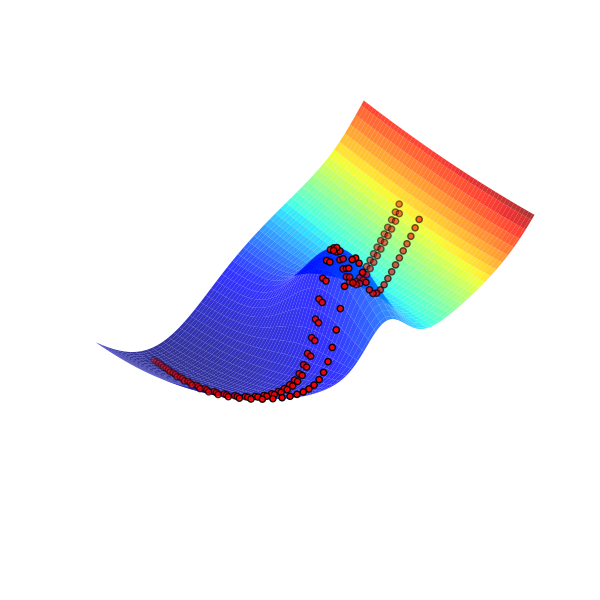

In [28]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)

steps = 20
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.jet(norm(potential))

im = ax.plot_surface(x_embedding, y_embedding, z_embedding, cmap='jet', edgecolor='none', antialiased=True, alpha=0.8, facecolors=colors)
ax.scatter(train_embedding[::steps, 0], train_embedding[::steps, 1], train_embedding[::steps, 2], s=20, edgecolors='k', c='red', zorder=10)

ax.set_xlabel('$y^1$')
ax.set_ylabel('$y^2$')
ax.set_zlabel('$y^3$')

# Adjust plot limits, if necessary
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)

ax.axis('off')

ax.view_init(elev=30, azim=-30)  # Adjust the elevation (up/down) and azimuth (left/right) an

# # Add colorbar without ticks and labels
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=10)

# cbar.ax.set_yticklabels([])
# cbar.ax.tick_params(length=0)
# cbar.outline.set_visible(False)  # Remove colorbar frame

# # Shrink colorbar to dimensions of the plot
# cbar.ax.set_position([0.52, 0.1, 0.03, 0.8])  # Adjust colorbar position and width

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_embedding_first.png', format='png', dpi=300, bbox_inches="tight")

### Metric

In [ ]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)

x_range = (max_ax[0] - min_ax[0]).abs()
y_range = (max_ax[1] - min_ax[1]).abs()
evals /= 500*torch.tensor([y_range/x_range/10,1.0]).to(device)

ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

In [ ]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Plot the filled contour
contour = ax.contourf(x, y, det_metric, 500, cmap="jet")

# Plot scattered points
ax.scatter(x[10::10, 10::10], y[10::10, 10::10], color="k", s=5)

# Plot ellipses
for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i, :], ellipses_y[i, :], color="k", linewidth=1.5, alpha=0.8)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=0.2)
cax.yaxis.set_label_position("right")
norm = plt.Normalize(vmin=det_metric.min(), vmax=det_metric.max())
colors = plt.cm.jet(norm(det_metric))
mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
cbar = fig.colorbar(mappable, cax=cax)
cbar.outline.set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
cbar.set_label(r'$|G|$', fontsize=24, rotation=0, labelpad=25)

# Set labels and tick sizes
# ax.set_xlabel('$q_1$', fontsize=24)
# ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

# Adjust layout
fig.tight_layout()
fig.savefig('../outputs/synthetic_detmetric_first.png', format='png', dpi=300, bbox_inches="tight")

### Inverse Metric Ellispses on Streamlines

In [ ]:
eval_scale = 10
x_sampled = torch.from_numpy(streamlines[:, 0, :dim]).float().to(device).requires_grad_(True)
v_sampled = torch.from_numpy(streamlines[:, 0, dim:]).float().to(device).requires_grad_(True)
sampled_embedding = embedding(x_sampled)

metric_sampled = model.embedding.pullmetric(sampled_embedding, model.embedding.jacobian(x_sampled, sampled_embedding))
metric_evals,metric_evecs = torch.linalg.eigh(metric_sampled.inverse())
metric_evals/= torch.tensor([100,100]).to(device)

metric_ellipses = torch.stack((metric_evals[:, 0].unsqueeze(-1)*theta.cos(), metric_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
metric_ellipses = torch.bmm(metric_evecs, metric_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()

In [ ]:
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

step = 50
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')

ax.scatter(x_sampled[::step, 0].detach().cpu(), x_sampled[::step, 1].detach().cpu(), color="k", s=15, zorder=10)

for i in range(0, metric_ellipses.shape[0], step):
    ax.plot(x_sampled[i, 0].detach().cpu() + metric_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + metric_ellipses[i, :, 1], color="k", linewidth=1.5)
    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)

# Set labels and tick sizes
ax.set_xlabel('$q_1$', fontsize=24)
ax.set_ylabel('$q_2$', fontsize=24, rotation=0, labelpad=20)
# ax.tick_params(axis='both', which='major', labelsize=16)

# Set axis limits
ax.set_xlim([min_ax[0].cpu(), max_ax[0].cpu()])
ax.set_ylim([min_ax[1].cpu(), max_ax[1].cpu()])

# Hide spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Improve plot layout
fig.tight_layout()

fig.savefig('../outputs/synthetic_metric_first.png', format='png', dpi=300, bbox_inches="tight")